## Get Data

In [7]:
import os
import sys
from sqlalchemy.orm import sessionmaker

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from db.db_conn import engine
from db.models import FactFunding, DimensionOrganization, DimensionLocation, DimensionIndustry, InvestorMapping, DimensionInvestor, IndustryMapping
import pandas as pd

# Set up session
Session = sessionmaker(bind=engine)
session = Session()

# Create the join query with all columns
query = (
    session.query(FactFunding, DimensionOrganization, DimensionLocation, DimensionIndustry, DimensionInvestor)
    .join(DimensionOrganization, FactFunding.organization_id == DimensionOrganization.organization_id)
    .join(DimensionLocation, DimensionOrganization.location_id == DimensionLocation.location_id, isouter=True)
    .join(IndustryMapping, DimensionOrganization.organization_id == IndustryMapping.organization_id, isouter=True)
    .join(DimensionIndustry, IndustryMapping.industry_id == DimensionIndustry.industry_id, isouter=True)
    .join(InvestorMapping, FactFunding.transaction_id == InvestorMapping.transaction_id, isouter=True)
    .join(DimensionInvestor, InvestorMapping.investor_id == DimensionInvestor.investor_id, isouter=True)
)

# Execute the query and load results into a DataFrame
big_df = pd.read_sql(query.statement, session.bind)
session.close()

# Display information about the merged DataFrame
print(big_df.columns)

Index(['transaction_id', 'organization_id', 'transaction_name',
       'transaction_name_url', 'money_raised', 'money_raised_currency',
       'money_raised_usd', 'funding_type', 'announced_date',
       'pre_money_valuation', 'pre_money_valuation_currency',
       'pre_money_valuation_usd', 'funding_stage', 'number_of_funding_rounds',
       'total_funding_amount', 'total_funding_currency',
       'total_funding_amount_usd', 'equity_only', 'funding_status',
       'number_of_investors', 'organization_id_1', 'organization_name',
       'organization_website', 'organization_name_url',
       'organization_description', 'location_id', 'location_id_1', 'city',
       'region', 'country', 'continent', 'longitude', 'latitude',
       'industry_id', 'industry', 'investor_id', 'investor'],
      dtype='object')


## Create cluste based on Total Funding Amount in USD

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans

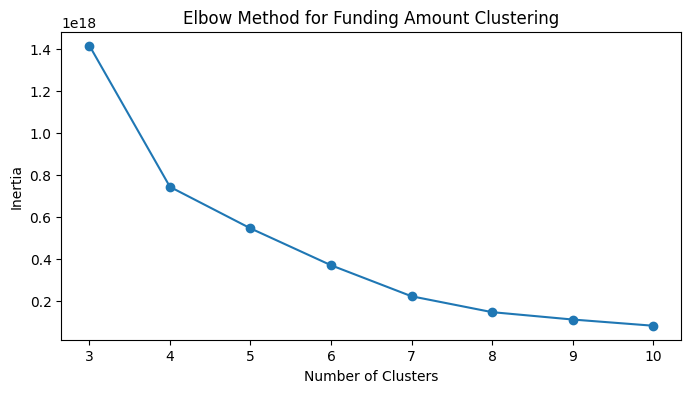

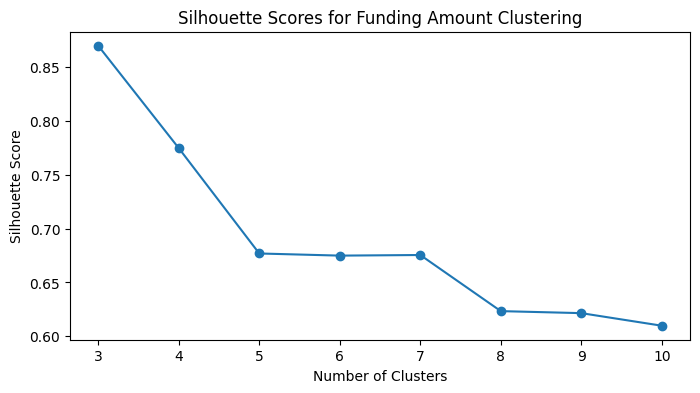

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_36619/1369494160.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_fa['funding_amount_cluster'] = kmeans.fit_predict(funding_amount)


Unique Clusters: [0 1 2]


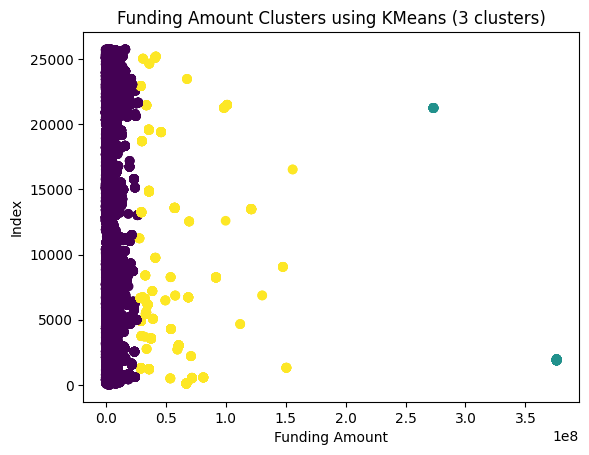

In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create a cleared copy of the dataframe
df_na_fa = big_df.dropna(subset=['total_funding_amount_usd'])

funding_amount = df_na_fa[['total_funding_amount_usd']]

# Finding the best number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(3, 11)  # Try different values for n_clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(funding_amount)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(funding_amount, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Funding Amount Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Funding Amount Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on Elbow or Silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]  # or choose based on elbow
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_na_fa['funding_amount_cluster'] = kmeans.fit_predict(funding_amount)

# Display unique clusters
print("Unique Clusters:", np.unique(df_na_fa['funding_amount_cluster']))

# Plotting the clusters
plt.scatter(funding_amount, range(len(funding_amount)), c=df_na_fa['funding_amount_cluster'], cmap='viridis')
plt.xlabel('Funding Amount')
plt.ylabel('Index')
plt.title(f'Funding Amount Clusters using KMeans ({optimal_clusters} clusters)')
plt.show()

# Left join the 'funding_amount_cluster' column with the original big_df
big_df = big_df.merge(df_na_fa[['funding_amount_cluster']], left_index=True, right_index=True, how='left')


## Create cluste based on Money Raised in USD

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans

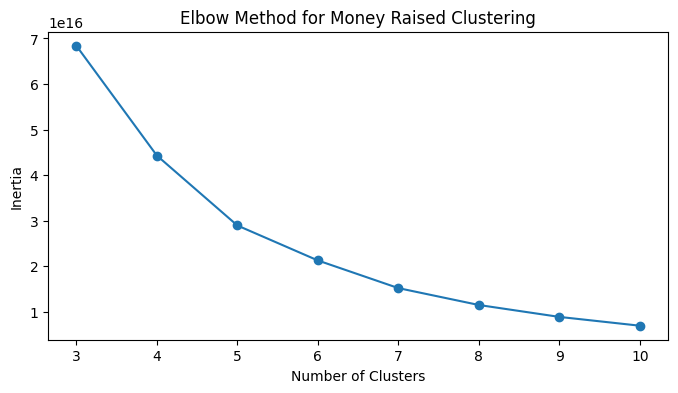

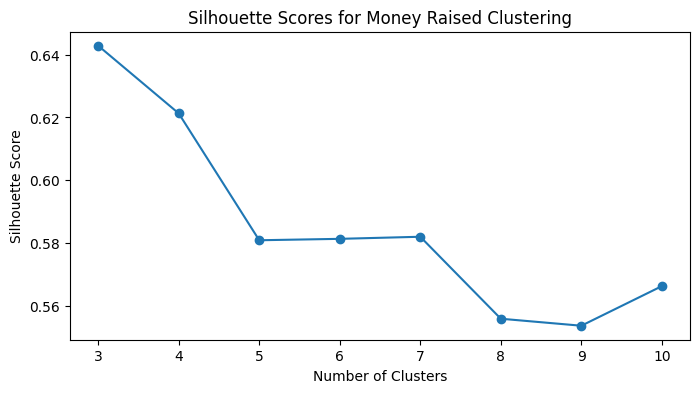

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_36619/3311514427.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na_mr['money_raised_cluster'] = kmeans.fit_predict(money_raised)


Unique Clusters: [0 1 2]


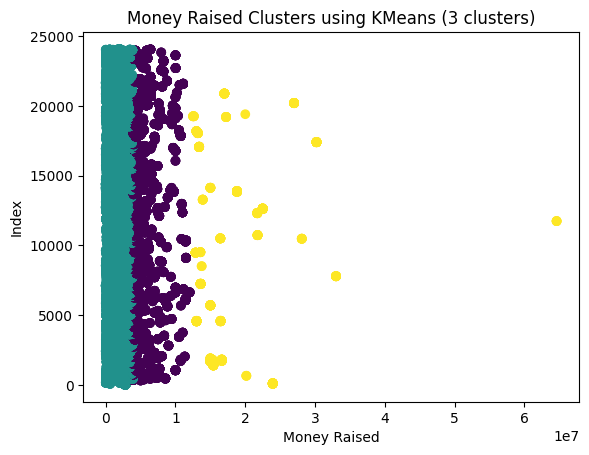

In [9]:
# Create a cleared copy of the dataframe
df_na_mr = big_df.dropna(subset=['money_raised_usd'])

money_raised = df_na_mr[['money_raised_usd']]

# Finding the best number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(3, 11)  # Try different values for n_clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(money_raised)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(money_raised, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Money Raised Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Money Raised Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on Elbow or Silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]  # or choose based on elbow
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_na_mr['money_raised_cluster'] = kmeans.fit_predict(money_raised)

# Display unique clusters
print("Unique Clusters:", np.unique(df_na_mr['money_raised_cluster']))

# Plotting the clusters
plt.scatter(money_raised, range(len(money_raised)), c=df_na_mr['money_raised_cluster'], cmap='viridis')
plt.xlabel('Money Raised')
plt.ylabel('Index')
plt.title(f'Money Raised Clusters using KMeans ({optimal_clusters} clusters)')
plt.show()

# Left join the 'money_raised_cluster' column with the original big_df
big_df = big_df.merge(df_na_mr[['money_raised_cluster']], left_index=True, right_index=True, how='left')


## Cluster Investors based on their strategy

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans

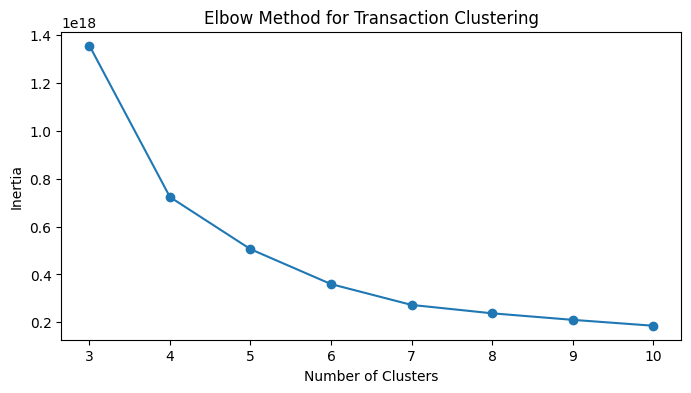

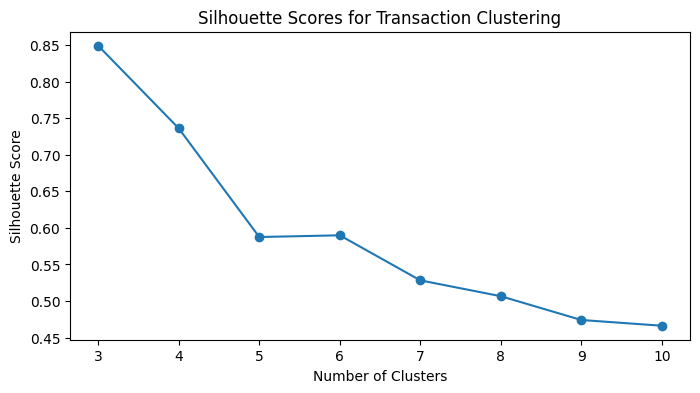

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_36619/3205363181.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mv['transaction_cluster'] = kmeans.fit_predict(features)


Unique Transaction Clusters: [0 1 2]


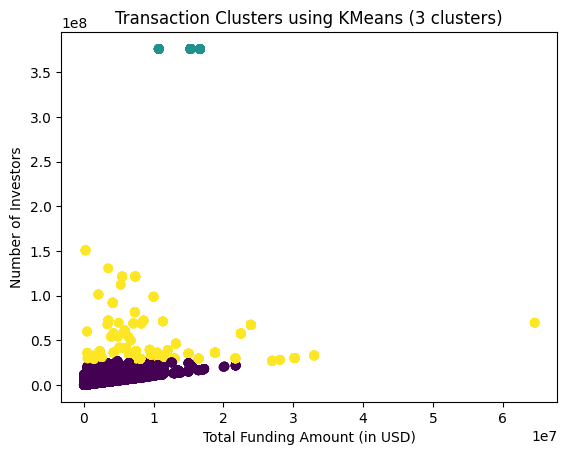

In [10]:
# Drop rows with NA in relevant columns
df_mv = big_df.dropna(subset=['money_raised_usd', 'funding_type', 'funding_stage', 'total_funding_amount_usd'])

# Clustering Total Funding Amount using KMeans
features = df_mv[['money_raised_usd', 'funding_type', 'funding_stage', 'total_funding_amount_usd']]

# Encode categorical variables like 'Funding Type' and 'Funding Stage'
features = pd.get_dummies(features, columns=['funding_type', 'funding_stage'], drop_first=True)

# Finding the best number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(3, 11)  # Try different values for n_clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features, cluster_labels))

# Plotting the Elbow Method
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Transaction Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Transaction Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit KMeans with the optimal number of clusters (based on Elbow or Silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]  # or choose based on elbow
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_mv['transaction_cluster'] = kmeans.fit_predict(features)

# Display unique clusters
print("Unique Transaction Clusters:", np.unique(df_mv['transaction_cluster']))

# Plotting the clusters (using the first two features for visualization)
plt.scatter(features.iloc[:, 0], features.iloc[:, 1], c=df_mv['transaction_cluster'], cmap='viridis')
plt.xlabel('Total Funding Amount (in USD)')
plt.ylabel('Number of Investors')
plt.title(f'Transaction Clusters using KMeans ({optimal_clusters} clusters)')
plt.show()

# Left join the 'transaction_cluster' column with the original big_df
big_df = big_df.merge(df_mv[['transaction_cluster']], left_index=True, right_index=True, how='left')


In [11]:
# Generate descriptive names for each cluster based on centroid values
cluster_centroids = kmeans.cluster_centers_
cluster_names = []
feature_means = features.mean(axis=0)
feature_std = features.std(axis=0)  # Calculate standard deviation for determining medium values
threshold_high = 0.7  # Threshold for significant high difference
threshold_low = 0.1  # Threshold for significant low difference

for i, centroid in enumerate(cluster_centroids):
    description = []
    for j, value in enumerate(centroid):
        if value > feature_means[j] + threshold_high * feature_std[j]:
            description.append(f"High {features.columns[j]}")
        elif value < feature_means[j] - threshold_low * feature_std[j]:
            description.append(f"Low {features.columns[j]}")
        else:
            description.append(f"Medium {features.columns[j]}")
    cluster_name = f"Cluster {i}: {', '.join(description) if description else 'No significant difference'}"
    cluster_names.append(cluster_name)
    print(cluster_name)

Cluster 0: Low money_raised_usd, Low total_funding_amount_usd, Medium funding_type_Seed
Cluster 1: High money_raised_usd, High total_funding_amount_usd, High funding_type_Seed
Cluster 2: High money_raised_usd, High total_funding_amount_usd, Medium funding_type_Seed


/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_36619/286320713.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if value > feature_means[j] + threshold_high * feature_std[j]:
/var/folders/cw/nsgz30_17pq84g4s1jh0lgtw0000gp/T/ipykernel_36619/286320713.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif value < feature_means[j] - threshold_low * feature_std[j]:


## Create Labels for Company Descriptions
Further it is tried to create a more unified label for the companies. Currently the description as well as the industry data field contain a variety of different labels. 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

# Combine 'Organization Industries' and 'Organization Description' fields
big_df['combined_text'] = big_df['industry'].fillna('') + ' ' + big_df['organization_description'].fillna('')

# Drop rows with empty combined text
df_combined = big_df.dropna(subset=['industry'])

# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_combined['industry'])

# Apply KMeans clustering
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_combined['company_cluster'] = kmeans.fit_predict(tfidf_matrix)

# Print unique clusters
print("Unique Company Clusters:", df_combined['company_cluster'].unique())

# Apply LDA on each cluster to generate topic-based labels
words = tfidf_vectorizer.get_feature_names_out()
for cluster_id in range(n_clusters):
    # Filter companies in the current cluster
    cluster_data = df_combined[df_combined['company_cluster'] == cluster_id]
    cluster_matrix = tfidf_vectorizer.transform(cluster_data['industry'])
    
    # Apply LDA to the cluster data
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(cluster_matrix)
    
    # Get the top words for the topic
    topic_words = [words[i] for i in lda.components_[0].argsort()[-5:]]
    print(f"Cluster {cluster_id} Label: {' '.join(topic_words)}")

# Merge cluster labels back to the original DataFrame
big_df = big_df.merge(df_combined[['company_cluster']], left_index=True, right_index=True, how='left')


/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Unique Company Clusters: [0 6 4 1 3 5 2]
Cluster 0 Label: fintech energy care services health
Cluster 1 Label: enablement energy electronic young saas
Cluster 2 Label: young human interaction vision computer
Cluster 3 Label: energy electronics young platforms commerce
Cluster 4 Label: energy electronics engineering enterprise software
Cluster 5 Label: embedded young ai intelligence artificial
Cluster 6 Label: engine email young information technology


## Company Embeddings based on labels
- These embeddings represent the semantic relationships between the companies. Companies with similar descriptions and industries should have embeddings that are close to each other in the high-dimensional embedding space.
- The reduced dimensions are named as "t-SNE Component 1", "t-SNE Component 2", and "t-SNE Component 3". These components do not have intrinsic meaning but represent transformations that maintain neighborhood relationships from the original space.
- Companies that fall into the same cluster are expected to have some degree of similarity in their industries and descriptions, meaning they might be working in similar domains or focusing on similar market segments.

/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans

Cluster 0 Label: information technology systems business ict
Cluster 1 Label: health care mental diagnostics personal
Cluster 2 Label: software young electronic energy enablement
Cluster 3 Label: apps mobile web desktop enterprise
Cluster 4 Label: saas marketplace packaging services home
Cluster 5 Label: artificial intelligence ai young embedded
Cluster 6 Label: manufacturing machinery industrial paper rubber


/Users/jonathan/Library/Mobile Documents/com~apple~CloudDocs/Master/3_Semester/Business Data Processing/cbs-bdp-market-review-dashboard/.venv/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:129: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)


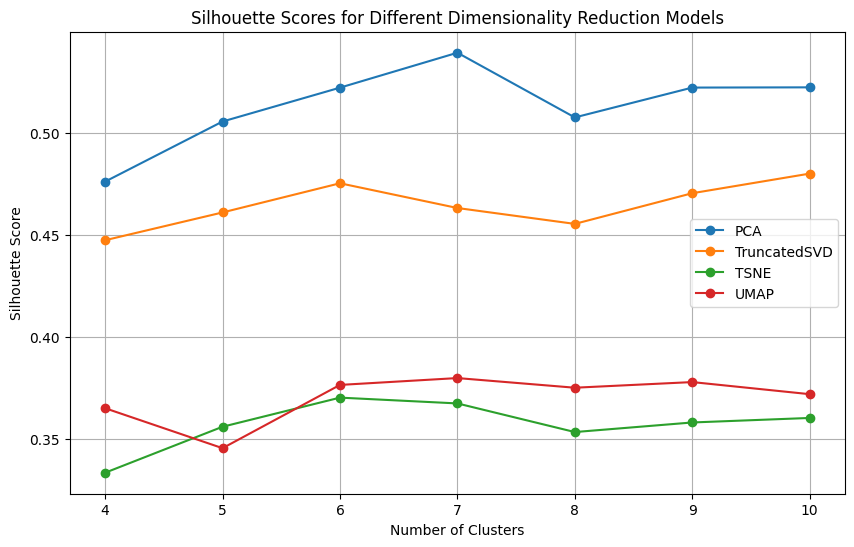

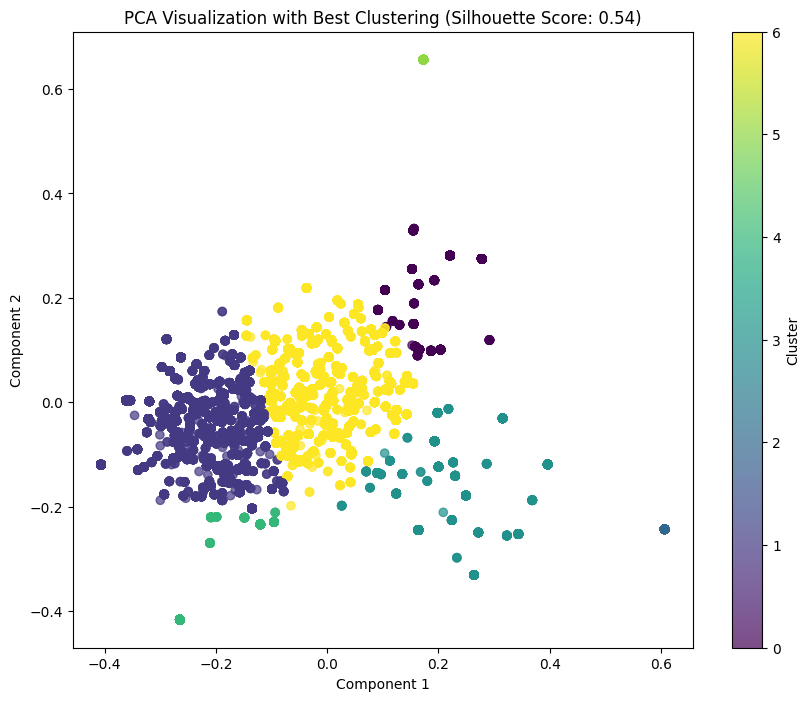

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer

# Load and clean column
big_df['cleaned_industries'] = big_df['industry'].fillna('').str.lower()

# Generate embeddings for 'Organization Industries' using Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
industries_embeddings = model.encode(big_df['cleaned_industries'].tolist(), convert_to_tensor=True)

# Convert embeddings to numpy
embeddings_np = industries_embeddings.cpu().numpy()

# Define dimensionality reduction models
dim_models = [PCA(n_components=2), TruncatedSVD(n_components=2), TSNE(n_components=2, perplexity=30, n_iter=3000), UMAP(n_components=2, n_neighbors=15)]
N_models = len(dim_models)

# Variables to store results for each model
results = []

# Iterate through dimensionality reduction models and find the best one
for dim_model in dim_models:
    model_name = dim_model.__class__.__name__
    reduced_embeddings = dim_model.fit_transform(embeddings_np)
    
    # Try KMeans with different numbers of clusters and store the results
    for n_clusters in range(4, 11):  # Try from 4 to 10 clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(reduced_embeddings)

        # Evaluate clustering with silhouette score
        sil_score = silhouette_score(reduced_embeddings, kmeans_labels)
        
        # Store the result for plotting
        results.append({
            "model_name": model_name,
            "n_clusters": n_clusters,
            "silhouette_score": sil_score,
            "reduced_embeddings": reduced_embeddings,
            "kmeans_labels": kmeans_labels
        })

# Extract the best result based on silhouette score
best_result = max(results, key=lambda x: x['silhouette_score'])

# Assign the best clustering labels to the DataFrame
big_df['company_cluster'] = best_result['kmeans_labels']

# Extract top keywords for each cluster using TF-IDF and NMF for cluster naming
n_clusters = best_result['n_clusters']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(big_df['cleaned_industries'])

# Create a dictionary to store cluster labels (names)
cluster_labels = {}

for cluster_id in range(n_clusters):
    # Filter companies in the current cluster
    cluster_data = big_df[big_df['company_cluster'] == cluster_id]['cleaned_industries']
    if cluster_data.empty:
        continue  # Skip if the cluster has no data
    cluster_matrix = tfidf_vectorizer.transform(cluster_data)
    
    # Apply NMF for topic extraction
    nmf = NMF(n_components=1, random_state=42)
    nmf.fit(cluster_matrix)
    
    # Get top keywords for labeling
    words = tfidf_vectorizer.get_feature_names_out()
    topic_weights = nmf.components_[0]
    top_keyword_indices = topic_weights.argsort()[-5:][::-1]
    topic_keywords = [words[i] for i in top_keyword_indices]
    label = ' '.join(topic_keywords)
    
    # Assign the label to the cluster
    cluster_labels[cluster_id] = label
    big_df.loc[big_df['company_cluster'] == cluster_id, 'industry_label'] = label
    print(f"Cluster {cluster_id} Label: {label}")

# Plot silhouette scores for all models
plt.figure(figsize=(10, 6))
for model in dim_models:
    model_name = model.__class__.__name__
    model_results = [res for res in results if res['model_name'] == model_name]
    cluster_counts = [res['n_clusters'] for res in model_results]
    silhouette_scores = [res['silhouette_score'] for res in model_results]
    
    plt.plot(cluster_counts, silhouette_scores, marker='o', label=model_name)

plt.title('Silhouette Scores for Different Dimensionality Reduction Models')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot the best model's clustering results
plt.figure(figsize=(10, 8))
best_model_name = best_result['model_name']
best_reduced_embeddings = best_result['reduced_embeddings']
best_kmeans_labels = best_result['kmeans_labels']

scatter = plt.scatter(best_reduced_embeddings[:, 0], best_reduced_embeddings[:, 1], c=best_kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title(f'{best_model_name} Visualization with Best Clustering (Silhouette Score: {best_result["silhouette_score"]:.2f})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.show()

# Assign the best clustering labels to the DataFrame
big_df['company_cluster'] = best_kmeans_labels


## Update data frame with new columns and push into Database

In [25]:
from sqlalchemy.orm import Session
from tqdm import tqdm

def push_new_columns_to_db(df, funding_model, org_model, session: Session, funding_id_col='transaction_id', org_id_col='organization_id'):
    """
    Push new calculated columns from a DataFrame to the database for both FactFunding and DimensionOrganization.

    Parameters:
    - df (pd.DataFrame): DataFrame containing new data to be pushed to the database.
    - funding_model (SQLAlchemy Model): SQLAlchemy model representing FactFunding.
    - org_model (SQLAlchemy Model): SQLAlchemy model representing DimensionOrganization.
    - session (Session): Active SQLAlchemy session.
    - funding_id_col (str): Identifier column in FactFunding (default: 'transaction_id').
    - org_id_col (str): Identifier column in DimensionOrganization (default: 'organization_id').
    """
    try:
        # Loop through each row in the DataFrame with tqdm progress bar
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Updating database"):
            # Update FactFunding table for funding-related clusters
            if all(col in row.index for col in ['funding_amount_cluster', 'money_raised_cluster', 'transaction_cluster']):
                funding_record = session.query(funding_model).filter(getattr(funding_model, funding_id_col) == row[funding_id_col]).first()
                
                if funding_record:
                    funding_record.funding_amount_cluster = row['funding_amount_cluster']
                    funding_record.money_raised_cluster = row['money_raised_cluster']
                    funding_record.transaction_cluster = row['transaction_cluster']
                    session.add(funding_record)

            # Update DimensionOrganization table for company cluster
            if 'company_cluster' in row.index:
                org_record = session.query(org_model).filter(getattr(org_model, org_id_col) == row[org_id_col]).first()
                
                if org_record:
                    org_record.company_description_cluster = row['company_cluster']
                    session.add(org_record)

        # Commit all updates to the database
        session.commit()
        print("Database updated with new calculated columns successfully.")

    except Exception as e:
        session.rollback()  # Rollback if there is any issue
        print(f"Error while updating the database: {e}")


In [26]:
from sqlalchemy.orm import sessionmaker
from db.db_conn import engine  # Ensure this is your correct engine path

# Create a session factory bound to the engine
Session = sessionmaker(bind=engine)


In [27]:
with Session() as session:
    push_new_columns_to_db(big_df, FactFunding, DimensionOrganization, session, funding_id_col='transaction_id', org_id_col='organization_id')


Updating database: 100%|██████████| 29579/29579 [45:54<00:00, 10.74it/s]  


Database updated with new calculated columns successfully.
